# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet201, EfficientNetB3, ResNet50
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import gc
from tensorflow.keras import backend as K
import itertools
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

tf.random.set_seed(42)
np.random.seed(42)


USE_AUGMENTATION_AND_OVERSAMPLING = True
print(f"Using augmentation and oversampling: {USE_AUGMENTATION_AND_OVERSAMPLING}")

Mounted at /content/drive
Using augmentation and oversampling: True


# Preparing data

In [2]:
data_path = '/content/dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)

import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')
zip_ref.extractall(data_path)
zip_ref.close()

csv_path = os.path.join(data_path, 'HAM10000_metadata.csv')
images_part1 = os.path.join(data_path, 'HAM10000_images_part_1')
images_part2 = os.path.join(data_path, 'HAM10000_images_part_2')

df_data = pd.read_csv(csv_path).set_index('image_id')

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df_data.dx = df_data.dx.astype('category', copy=True)
df_data['label_numeric'] = df_data.dx.cat.codes
df_data['label'] = df_data.dx
df_data['lesion_type'] = df_data.dx.map(lesion_type_dict)

imageid_path_dict = {}

for image_folder in [images_part1, images_part2]:
    if os.path.exists(image_folder):
        for image_file in os.listdir(image_folder):
            if image_file.endswith('.jpg'):
                image_id = os.path.splitext(image_file)[0]
                imageid_path_dict[image_id] = os.path.join(image_folder, image_file)

df_data['path'] = df_data.index.map(lambda x: imageid_path_dict.get(x, None))

df_data = df_data.dropna(subset=['path'])

print(f"Total images loaded: {len(df_data)}")
print("\nDiagnosis distribution:")
dx_counts = df_data['dx'].value_counts()
for dx, count in dx_counts.items():
    print(f"{lesion_type_dict[dx]} ({dx}): {count} images")

Total images loaded: 10015

Diagnosis distribution:
Melanocytic nevi (nv): 6705 images
Melanoma (mel): 1113 images
Benign keratosis (bkl): 1099 images
Basal cell carcinoma (bcc): 514 images
Actinic keratoses (akiec): 327 images
Vascular lesions (vasc): 142 images
Dermatofibroma (df): 115 images


#  Data Visualization and Split

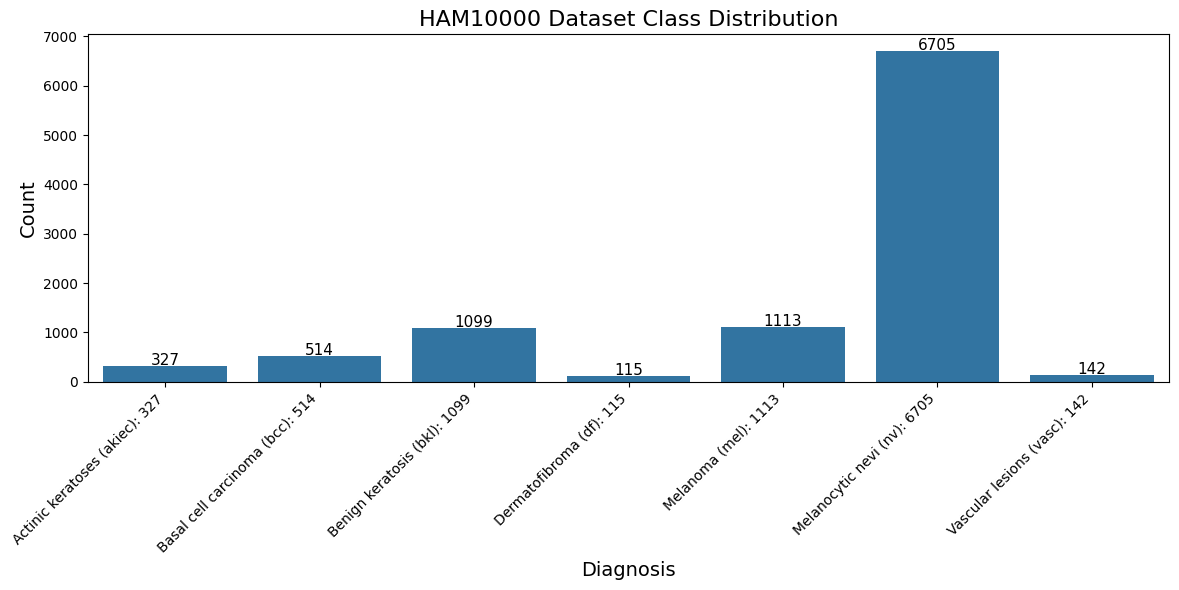

Duplicate lesion_ids: 2545 out of 10015


<ipython-input-3-68a55786744b>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-3-68a55786744b>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


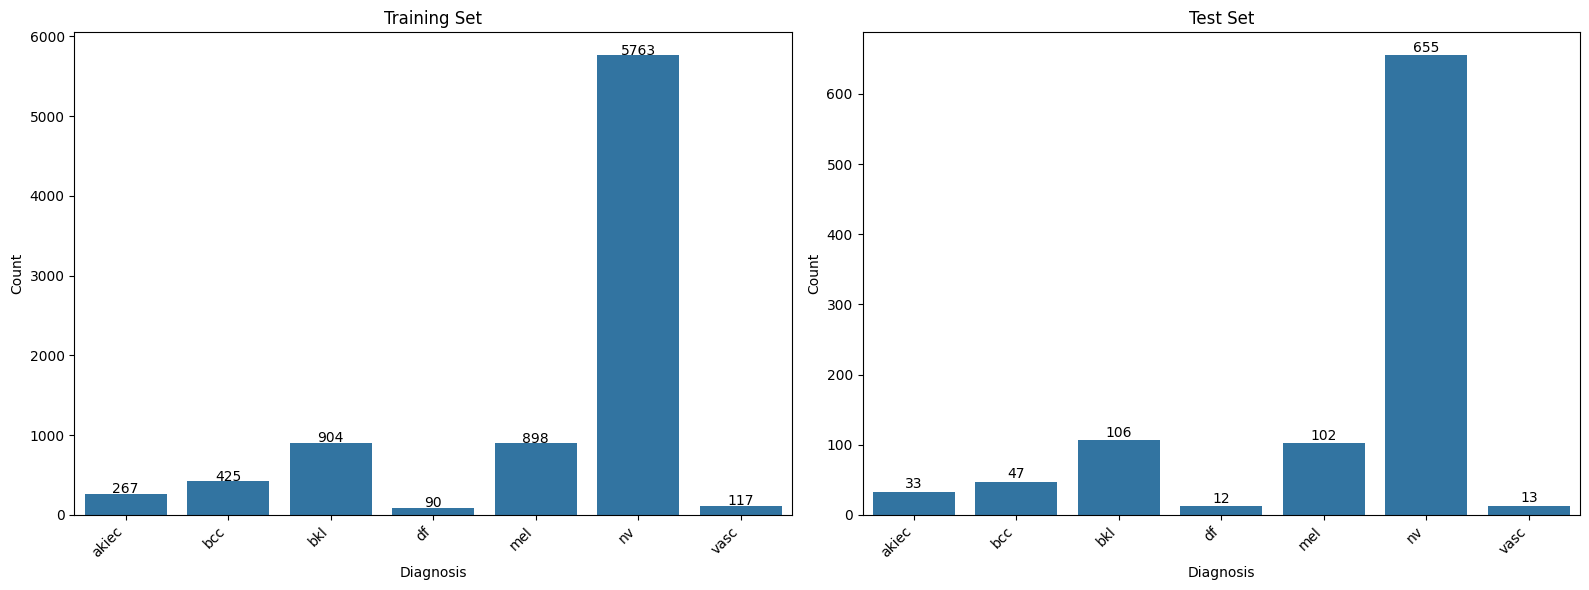

Training set: 8464 images
Test set: 968 images


In [3]:
def plot_data_distribution(df, title='Class Distribution'):
    plt.figure(figsize=(12, 6))
    counts = df['dx'].value_counts().sort_index()

    labels = [f"{lesion_type_dict[dx]} ({dx}): {count}" for dx, count in counts.items()]

    ax = sns.barplot(x=counts.index, y=counts.values)

    plt.title(title, fontsize=16)
    plt.xlabel('Diagnosis', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(range(len(counts)), labels, rotation=45, ha='right')

    for i, count in enumerate(counts.values):
        ax.text(i, count + 20, str(count), ha='center', fontsize=11)

    plt.tight_layout()
    plt.show()

plot_data_distribution(df_data, 'HAM10000 Dataset Class Distribution')

def check_duplicates(df, col='lesion_id'):
    unique_list = df[col].unique().tolist()
    num_duplicates = len(df) - len(unique_list)
    return num_duplicates

num_duplicates = check_duplicates(df_data)
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_data)}')

df_train, df_test = train_test_split(df_data, test_size=0.1, stratify=df_data['label_numeric'], random_state=42)

df_test = df_test.reset_index()
df_train = df_train.reset_index()

df_test = df_test.drop_duplicates(subset='lesion_id', keep="first")

test_lesion_ids = set(df_test['lesion_id'].unique())
df_train = df_train[~df_train['lesion_id'].isin(test_lesion_ids)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (df, title) in enumerate([(df_train, 'Training Set'), (df_test, 'Test Set')]):
    counts = df['dx'].value_counts().sort_index()
    ax = axes[i]
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diagnosis')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    for j, count in enumerate(counts.values):
        ax.text(j, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

print(f"Training set: {len(df_train)} images")
print(f"Test set: {len(df_test)} images")

# Data Augmentation and Balance Function

In [4]:
def balance_data(train_data, oversample=True):
    if not oversample:
        print("Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False")
        return train_data

    balanced_train_data = []
    class_counts = train_data['label_numeric'].value_counts()

    nv_indices = train_data[train_data['dx'] == 'nv'].index
    nv_label = list(train_data[train_data['dx'] == 'nv']['label_numeric'].unique())[0]

    for class_label, count in class_counts.items():
        class_data = train_data[train_data['label_numeric'] == class_label]
        class_name = list(train_data[train_data['label_numeric'] == class_label]['dx'].unique())[0]

        if class_label == nv_label:
            balanced_train_data.append(class_data)
            print(f"Class '{class_name}' (original): {len(class_data)} samples")
        else:
            if count < 1500:
                n_samples_needed = 1500
                n_oversample = n_samples_needed - count

                full_copies = n_oversample // count
                remaining = n_oversample % count

                oversampled = pd.concat([class_data] * full_copies) if full_copies > 0 else pd.DataFrame()

                if remaining > 0:
                    additional = class_data.sample(n=remaining, replace=False, random_state=42)
                    oversampled = pd.concat([oversampled, additional])

                final_class_data = pd.concat([class_data, oversampled])
                balanced_train_data.append(final_class_data)
                print(f"Class '{class_name}' (oversampled): {len(final_class_data)} samples (original: {count})")
            else:
                balanced_train_data.append(class_data.sample(n=1500, random_state=42))
                print(f"Class '{class_name}' (downsampled): 1500 samples (original: {count})")

    balanced_data = pd.concat(balanced_train_data)
    return balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

common_aug_args = {
    "featurewise_center": False,
    "samplewise_center": False,
    "featurewise_std_normalization": False,
    "samplewise_std_normalization": False,
    "zca_whitening": False,
    "rotation_range": 10,
    "zoom_range": 0.1,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "horizontal_flip": False,
    "vertical_flip": False,
    "fill_mode": 'nearest'
}

if USE_AUGMENTATION_AND_OVERSAMPLING:
    tr_gen_rescale = ImageDataGenerator(rescale=1.0/255.0, **common_aug_args)
    tr_gen_no_rescale = ImageDataGenerator(**common_aug_args)
else:
    tr_gen_rescale = ImageDataGenerator(rescale=1.0/255.0)
    tr_gen_no_rescale = ImageDataGenerator()

ts_gen_rescale = ImageDataGenerator(rescale=1.0/255.0)
ts_gen_no_rescale = ImageDataGenerator()

# Models

In [5]:
def create_densenet_model(input_shape=(224, 224, 3), num_classes=7):
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

def create_efficientnet_model(input_shape=(300, 300, 3), num_classes=7):
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

def create_resnet50_model(input_shape=(224, 224, 3), num_classes=7):
    base_model = ResNet50(
        include_top=False,
        input_shape=input_shape,
        pooling='avg',
        weights='imagenet'
    )

    model = Sequential([
        base_model,
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    return model

def compile_model(model):
    opt = Adam(learning_rate=0.001)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

model_configs = {
    "DenseNet201": {"img_size": (224, 224), "use_rescale": True, "model_func": create_densenet_model},
    # "EfficientNetB3": {"img_size": (300, 300), "use_rescale": False, "model_func": create_efficientnet_model},
    # "ResNet50": {"img_size": (224, 224), "use_rescale": True, "model_func": create_resnet50_model}
}

# Functions for Visualization

In [6]:
def plot_roc_curves(fpr, tpr, roc_auc, class_names, title='ROC Curves'):
    plt.figure(figsize=(12, 10))

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_training_history(history, model_name):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Training')
    if 'val_auc' in history.history:
        plt.plot(history.history['val_auc'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title(f'{model_name} - AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# K-Fold Cross-Validation Training


Starting 5-Fold CV for model: DenseNet201

--- Fold 1 ---

Balancing training data...
Class 'nv' (original): 4610 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 719)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 214)
Class 'vasc' (oversampled): 1500 samples (original: 93)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13610 samples
Found 13610 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 94080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 94080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    48,169,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,560,583 (253.91 MB)

 Trainable params: 48,237,319 (184.01 MB)

 Non-trainable params: 18,323,264 (69.90 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 325s 648ms/step - accuracy: 0.4961 - auc: 0.8232 - loss: 1.5776 - val_accuracy: 0.7631 - val_auc: 0.9634 - val_loss: 0.6495 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 213s 501ms/step - accuracy: 0.7000 - auc: 0.9419 - loss: 0.8319 - val_accuracy: 0.7608 - val_auc: 0.9649 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 215s 505ms/step - accuracy: 0.7465 - auc: 0.9590 - loss: 0.6958 - val_accuracy: 0.7755 - val_auc: 0.9657 - val_loss: 0.6208 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 215s 503ms/step - accuracy: 0.7771 - auc: 0.9670 - loss: 0.6204 - val_accuracy: 0.7779 - val_auc: 0.9663 - val_loss: 0.6235 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 215s 505ms/step - accuracy: 0.7924 - auc: 0.9724 - loss: 0.5676 - val_accuracy: 0.7850 - val_auc: 0.9683 - val_loss: 0.5988 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 215s 505ms/step - ac

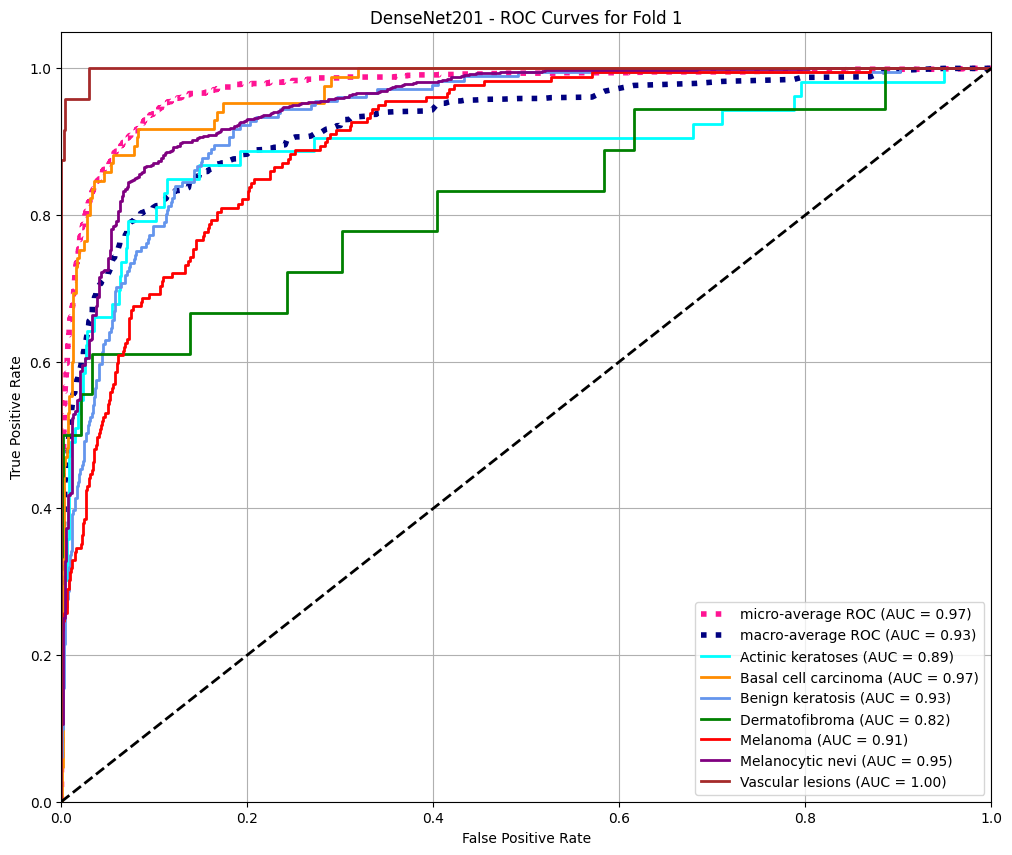


--- Fold 2 ---

Balancing training data...
Class 'nv' (original): 4610 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 718)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 214)
Class 'vasc' (oversampled): 1500 samples (original: 94)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13610 samples
Found 13610 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 310s 630ms/step - accuracy: 0.5009 - auc: 0.8262 - loss: 1.5975 - val_accuracy: 0.7608 - val_auc: 0.9623 - val_loss: 0.6647 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 220s 517ms/step - accuracy: 0.6911 - auc: 0.9382 - loss: 0.8612 - val_accuracy: 0.7407 - val_auc: 0.9518 - val_loss: 0.7486 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 221s 519ms/step - accuracy: 0.7506 - auc: 0.9593 - loss: 0.6903 - val_accuracy: 0.7826 - val_auc: 0.9689 - val_loss: 0.6058 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 219s 514ms/step - accuracy: 0.7694 - auc: 0.9664 - loss: 0.6269 - val_accuracy: 0.7915 - val_auc: 0.9721 - val_loss: 0.5720 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 216s 507ms/step - accuracy: 0.7892 - auc: 0.9712 - loss: 0.5778 - val_accuracy: 0.7738 - val_auc: 0.9670 - val_loss: 0.6250 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 217s 510ms/step - ac

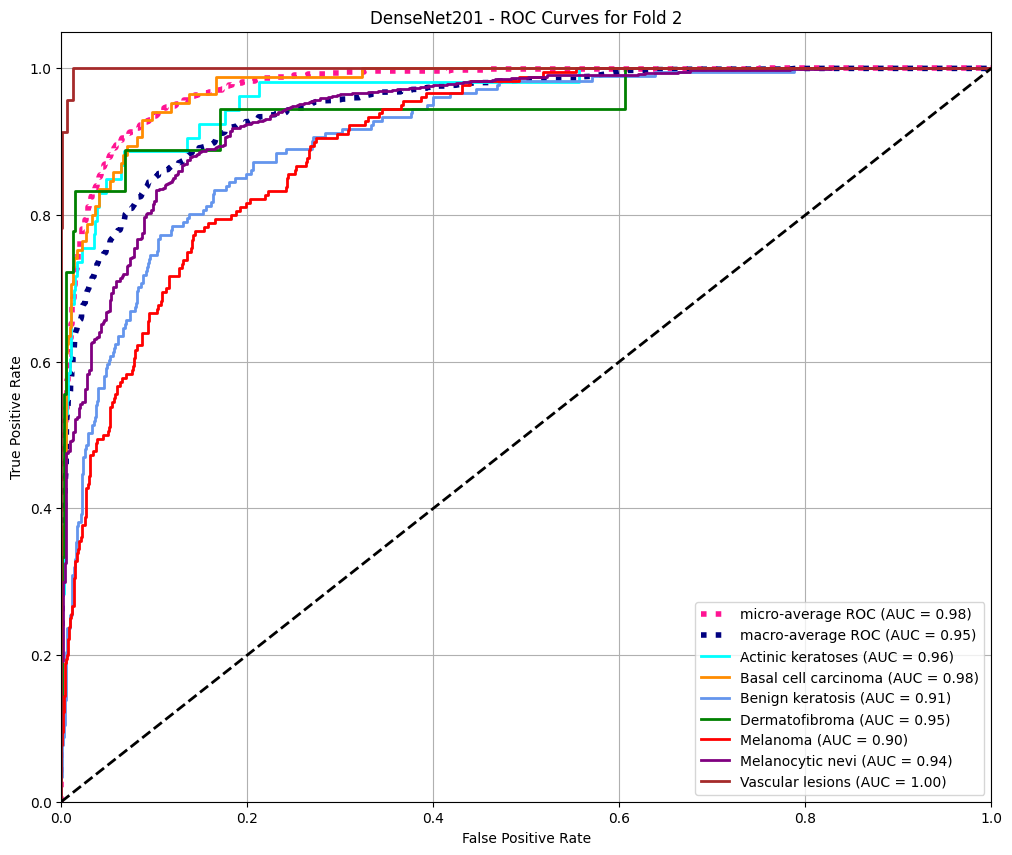


--- Fold 3 ---

Balancing training data...
Class 'nv' (original): 4610 samples
Class 'bkl' (oversampled): 1500 samples (original: 724)
Class 'mel' (oversampled): 1500 samples (original: 718)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 213)
Class 'vasc' (oversampled): 1500 samples (original: 94)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13610 samples
Found 13610 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 307s 629ms/step - accuracy: 0.4886 - auc: 0.8196 - loss: 1.5944 - val_accuracy: 0.7519 - val_auc: 0.9624 - val_loss: 0.6694 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 218s 512ms/step - accuracy: 0.6967 - auc: 0.9404 - loss: 0.8450 - val_accuracy: 0.7750 - val_auc: 0.9676 - val_loss: 0.6185 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 218s 511ms/step - accuracy: 0.7476 - auc: 0.9587 - loss: 0.6955 - val_accuracy: 0.7750 - val_auc: 0.9686 - val_loss: 0.6100 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 217s 510ms/step - accuracy: 0.7757 - auc: 0.9677 - loss: 0.6138 - val_accuracy: 0.7744 - val_auc: 0.9685 - val_loss: 0.6059 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.7955 - auc: 0.9725 - loss: 0.5641
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
426/426 ━━━━━━━━━━━━━━━━━━━━ 218s 510ms/step - accuracy: 0.7955 - auc:

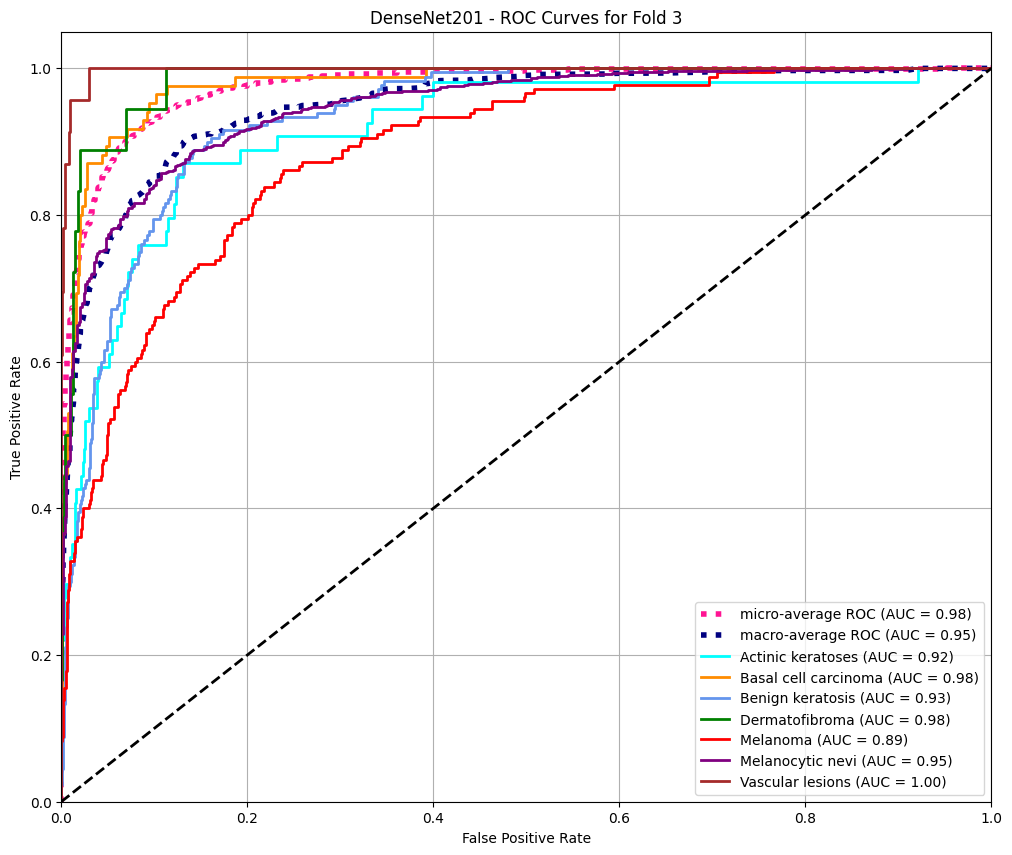


--- Fold 4 ---

Balancing training data...
Class 'nv' (original): 4611 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 718)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 213)
Class 'vasc' (oversampled): 1500 samples (original: 94)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13611 samples
Found 13611 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 311s 639ms/step - accuracy: 0.5114 - auc: 0.8249 - loss: 1.5870 - val_accuracy: 0.7566 - val_auc: 0.9604 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 216s 507ms/step - accuracy: 0.6909 - auc: 0.9402 - loss: 0.8463 - val_accuracy: 0.7797 - val_auc: 0.9669 - val_loss: 0.6226 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 213s 499ms/step - accuracy: 0.7497 - auc: 0.9578 - loss: 0.7074 - val_accuracy: 0.7732 - val_auc: 0.9670 - val_loss: 0.6171 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 213s 500ms/step - accuracy: 0.7748 - auc: 0.9673 - loss: 0.6204 - val_accuracy: 0.7885 - val_auc: 0.9710 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 215s 504ms/step - accuracy: 0.7860 - auc: 0.9711 - loss: 0.5798 - val_accuracy: 0.7986 - val_auc: 0.9710 - val_loss: 0.5757 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 214s 501ms/step - ac

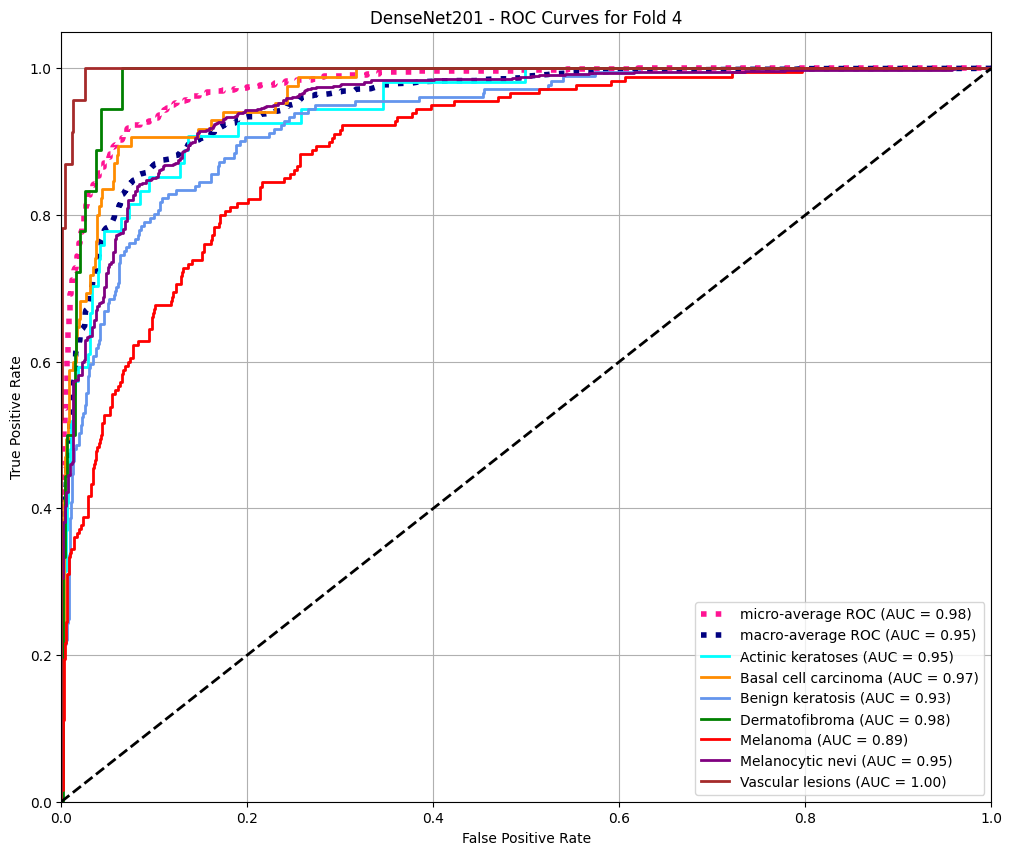


--- Fold 5 ---

Balancing training data...
Class 'nv' (original): 4611 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 719)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 214)
Class 'vasc' (oversampled): 1500 samples (original: 93)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13611 samples
Found 13611 validated image filenames belonging to 7 classes.
Found 1692 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 308s 629ms/step - accuracy: 0.4874 - auc: 0.8161 - loss: 1.5929 - val_accuracy: 0.7447 - val_auc: 0.9584 - val_loss: 0.7029 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 215s 505ms/step - accuracy: 0.6909 - auc: 0.9404 - loss: 0.8439 - val_accuracy: 0.7352 - val_auc: 0.9609 - val_loss: 0.6810 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 215s 505ms/step - accuracy: 0.7473 - auc: 0.9580 - loss: 0.7028 - val_accuracy: 0.7577 - val_auc: 0.9622 - val_loss: 0.6687 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 214s 502ms/step - accuracy: 0.7766 - auc: 0.9690 - loss: 0.6041 - val_accuracy: 0.7689 - val_auc: 0.9665 - val_loss: 0.6201 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 216s 507ms/step - accuracy: 0.7936 - auc: 0.9727 - loss: 0.5657 - val_accuracy: 0.7689 - val_auc: 0.9659 - val_loss: 0.6328 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 215s 504ms/step - ac

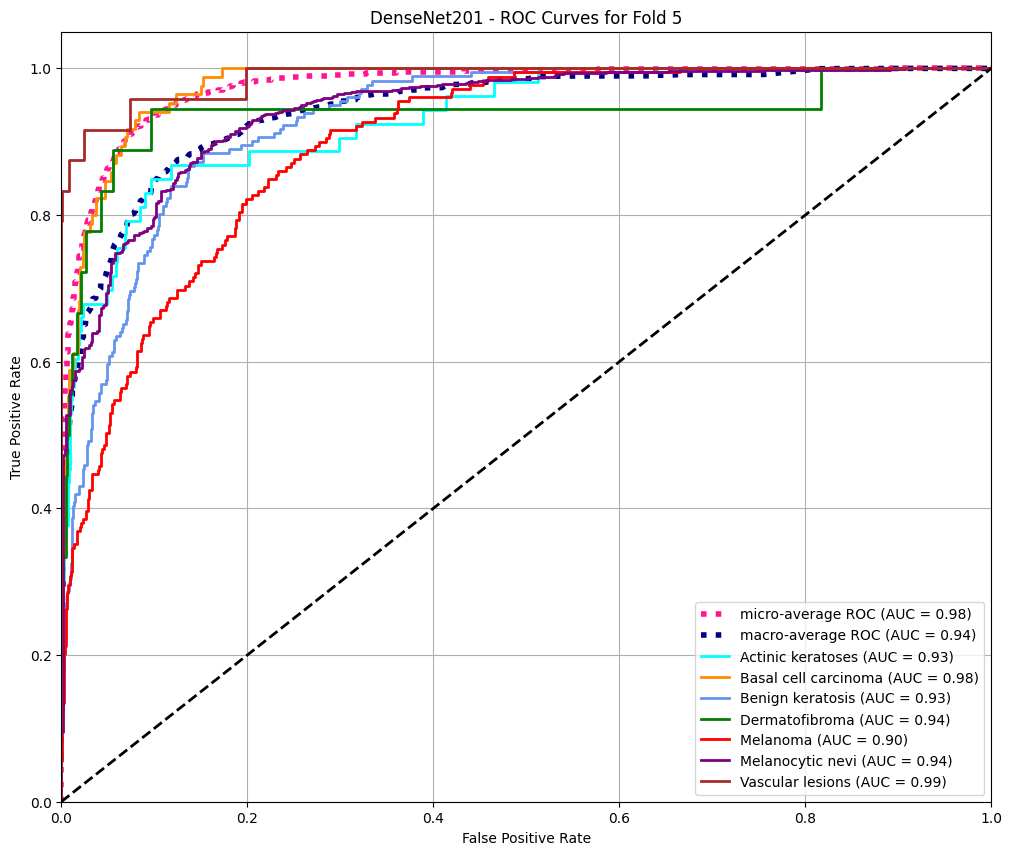


Model DenseNet201 - CV Validation Accuracies for each fold: [0.8192557692527771, 0.812167763710022, 0.8009450435638428, 0.8233904242515564, 0.8031914830207825]
Model DenseNet201 - Mean Validation Accuracy: 0.8118
Model DenseNet201 - CV Validation AUC for each fold: [0.9707393050193787, 0.9730013012886047, 0.9692572951316833, 0.9698634147644043, 0.9716651439666748]
Model DenseNet201 - Mean Validation AUC: 0.9709


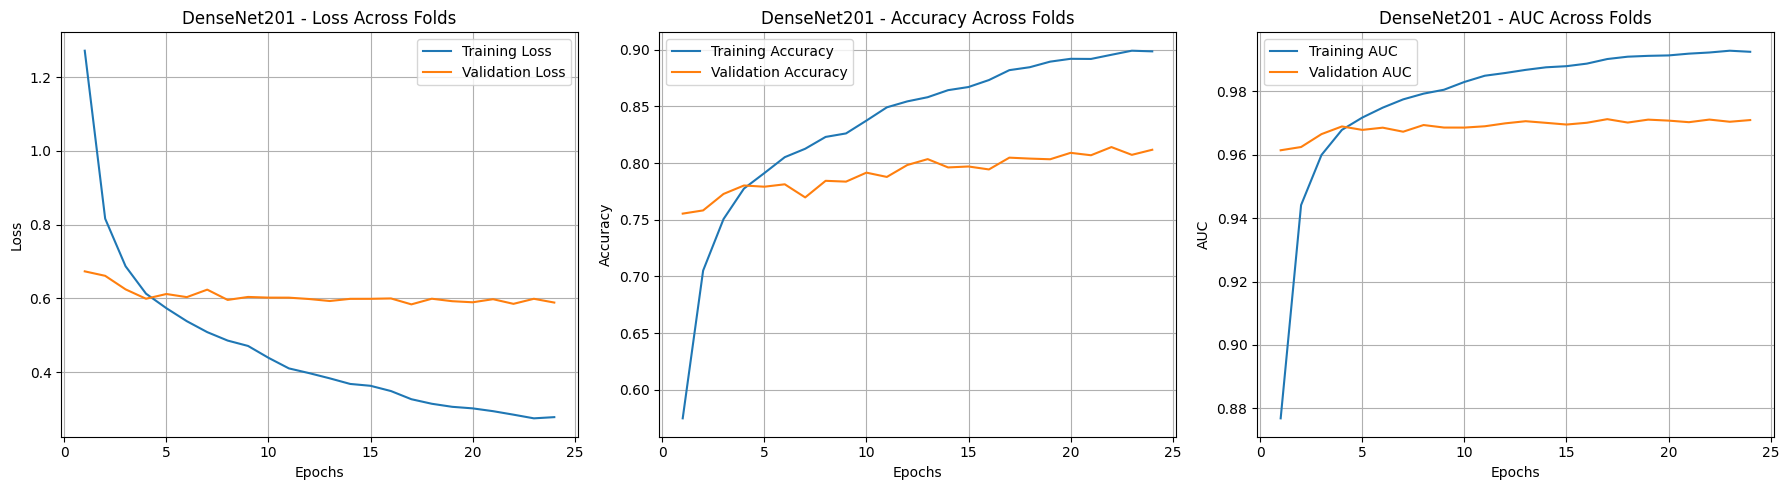

In [7]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
num_epochs = 24
batch_size = 32

for model_name, config in model_configs.items():
    print("\n================================================")
    print(f"Starting {num_folds}-Fold CV for model: {model_name}")
    print("================================================")

    img_size = config["img_size"]
    use_rescale = config["use_rescale"]
    model_func = config["model_func"]

    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []
    auc_per_fold = []
    val_loss_histories = []
    val_acc_histories = []
    val_auc_histories = []
    train_loss_histories = []
    train_acc_histories = []
    train_auc_histories = []

    roc_curves = {'fold': [], 'fpr': [], 'tpr': [], 'roc_auc': []}

    for train_index, val_index in skf.split(df_train, df_train['label_numeric']):
        print(f"\n--- Fold {fold_no} ---")
        train_data = df_train.iloc[train_index]
        val_data = df_train.iloc[val_index]

        print("\nBalancing training data...")
        balanced_train_data = balance_data(train_data, oversample=USE_AUGMENTATION_AND_OVERSAMPLING)
        print(f"Final balanced training set size: {len(balanced_train_data)} samples")

        if use_rescale:
            train_gen_fold = tr_gen_rescale.flow_from_dataframe(
                balanced_train_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=True,
                batch_size=batch_size
            )
            valid_gen_fold = ts_gen_rescale.flow_from_dataframe(
                val_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=False,
                batch_size=batch_size
            )
        else:
            train_gen_fold = tr_gen_no_rescale.flow_from_dataframe(
                balanced_train_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=True,
                batch_size=batch_size
            )
            valid_gen_fold = ts_gen_no_rescale.flow_from_dataframe(
                val_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=False,
                batch_size=batch_size
            )

        class_indices = train_gen_fold.class_indices
        class_names = list(class_indices.keys())

        model = model_func(input_shape=(img_size[0], img_size[1], 3), num_classes=len(class_indices))
        model = compile_model(model)

        if fold_no == 1:
            model.summary()

        history = model.fit(
            train_gen_fold,
            epochs=num_epochs,
            validation_data=valid_gen_fold,
            callbacks=[learning_rate_reduction],
            verbose=1
        )

        train_loss_histories.append(history.history['loss'])
        train_acc_histories.append(history.history['accuracy'])
        train_auc_histories.append(history.history['auc'])
        val_loss_histories.append(history.history['val_loss'])
        val_acc_histories.append(history.history['val_accuracy'])
        val_auc_histories.append(history.history['val_auc'])

        fold_val_loss, fold_val_acc, fold_val_auc = model.evaluate(valid_gen_fold)
        print(f"Fold {fold_no} - Validation Loss: {fold_val_loss:.4f}, Validation Accuracy: {fold_val_acc:.4f}, Validation AUC: {fold_val_auc:.4f}")

        loss_per_fold.append(fold_val_loss)
        acc_per_fold.append(fold_val_acc)
        auc_per_fold.append(fold_val_auc)

        y_pred = model.predict(valid_gen_fold)
        y_true = np.array(valid_gen_fold.classes)
        class_names = list(valid_gen_fold.class_indices.keys())

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(len(class_indices)):
            y_true_binary = np.array(y_true == i, dtype=int)
            fpr[i], tpr[i], _ = roc_curve(
                y_true_binary,
                y_pred[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(
            tf.keras.utils.to_categorical(y_true, num_classes=len(class_indices)).ravel(),
            y_pred.ravel()
        )
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_indices))]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(class_indices)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(class_indices)
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        roc_curves['fold'].append(fold_no)
        roc_curves['fpr'].append(fpr)
        roc_curves['tpr'].append(tpr)
        roc_curves['roc_auc'].append(roc_auc)

        lesion_names = [lesion_type_dict[key] for key in class_names]
        plot_roc_curves(fpr, tpr, roc_auc, lesion_names, f"{model_name} - ROC Curves for Fold {fold_no}")

        del model
        tf.keras.backend.clear_session()
        gc.collect()

        fold_no += 1

    print(f"\nModel {model_name} - CV Validation Accuracies for each fold: {acc_per_fold}")
    print(f"Model {model_name} - Mean Validation Accuracy: {np.mean(acc_per_fold):.4f}")
    print(f"Model {model_name} - CV Validation AUC for each fold: {auc_per_fold}")
    print(f"Model {model_name} - Mean Validation AUC: {np.mean(auc_per_fold):.4f}")

    avg_train_loss = np.mean(np.array(train_loss_histories), axis=0)
    avg_train_accuracy = np.mean(np.array(train_acc_histories), axis=0)
    avg_train_auc = np.mean(np.array(train_auc_histories), axis=0)
    avg_val_loss = np.mean(np.array(val_loss_histories), axis=0)
    avg_val_accuracy = np.mean(np.array(val_acc_histories), axis=0)
    avg_val_auc = np.mean(np.array(val_auc_histories), axis=0)
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, avg_train_loss, label='Training Loss')
    plt.plot(epochs_range, avg_val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Across Folds')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, avg_train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, avg_val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy Across Folds')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, avg_train_auc, label='Training AUC')
    plt.plot(epochs_range, avg_val_auc, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title(f'{model_name} - AUC Across Folds')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Final Training and Evaluation


Final Training and Evaluation for model: DenseNet201

Balancing full training data for final model...
Class 'nv' (original): 5763 samples
Class 'bkl' (oversampled): 1500 samples (original: 904)
Class 'mel' (oversampled): 1500 samples (original: 898)
Class 'bcc' (oversampled): 1500 samples (original: 425)
Class 'akiec' (oversampled): 1500 samples (original: 267)
Class 'vasc' (oversampled): 1500 samples (original: 117)
Class 'df' (oversampled): 1500 samples (original: 90)
Final balanced full training set size: 14763 samples
Found 14763 validated image filenames belonging to 7 classes.
Found 968 validated image filenames belonging to 7 classes.

--- Final training on full training data ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 279s 519ms/step - accuracy: 0.5018 - auc: 0.8242 - loss: 1.5923 - learning_rate: 0.0010
Epoch 2/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 223s 483ms/step - accuracy: 0.6880 - auc: 0.9358 - loss: 0.8774 - learning_rate: 0.0010
Epoch 3/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 223s 482ms/step - accuracy: 0.7355 - auc: 0.9561 - loss: 0.7210 - learning_rate: 0.0010
Epoch 4/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 223s 482ms/step - accuracy: 0.7613 - auc: 0.9633 - loss: 0.6569 - learning_rate: 0.0010
Epoch 5/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 222s 480ms/step - accuracy: 0.7821 - auc: 0.9689 - loss: 0.6030 - learning_rate: 0.0010
Epoch 6/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 223s 482ms/step - accuracy: 0.7919 - auc: 0.9726 - loss: 0.5626 - learning_rate: 0.0010
Epoch 7/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 222s 480ms/step - accuracy: 0.8016 - auc: 0.9748 - loss: 0.5378 - learning_rate: 0.0010
Epoch 8/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 221s 479ms/step - accuracy: 0.8052 - auc: 0.9761 - loss: 0.5252 

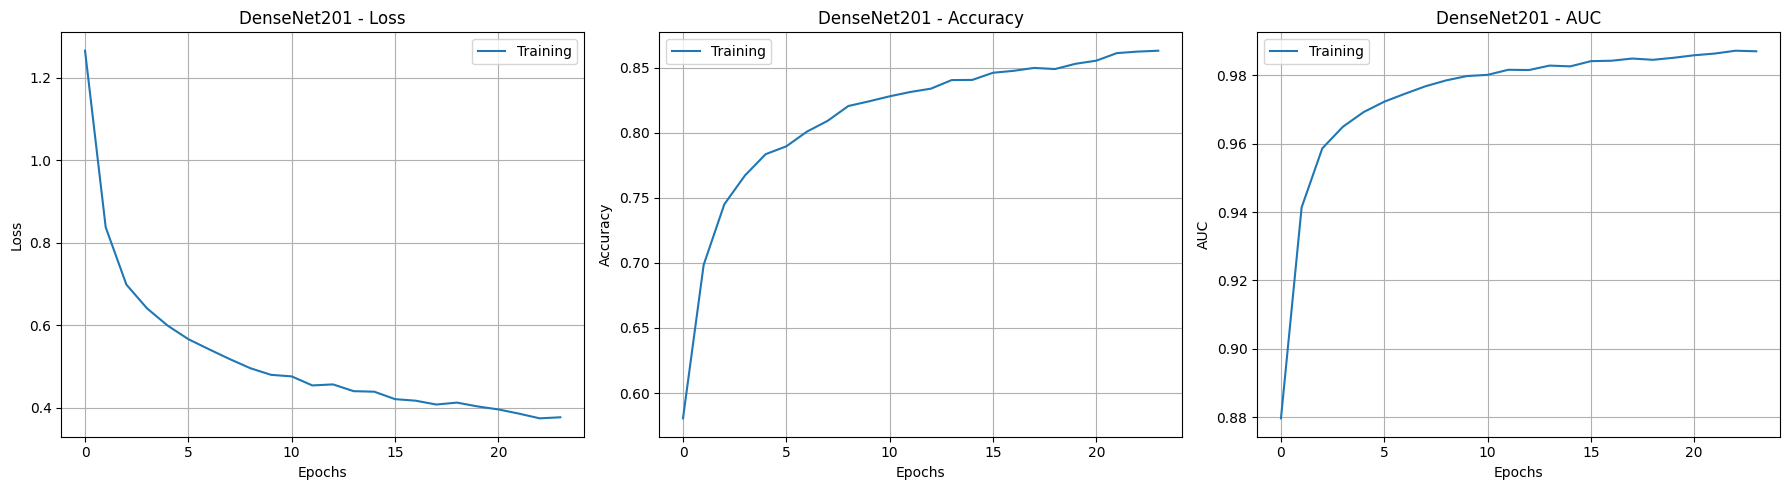


Evaluating on test set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 789ms/step - accuracy: 0.7626 - auc: 0.9551 - loss: 0.7756

Test Loss for DenseNet201: 0.7455
Test Accuracy for DenseNet201: 0.7655
Test AUC for DenseNet201: 0.9577

Generating predictions for ROC curves...
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 870ms/step


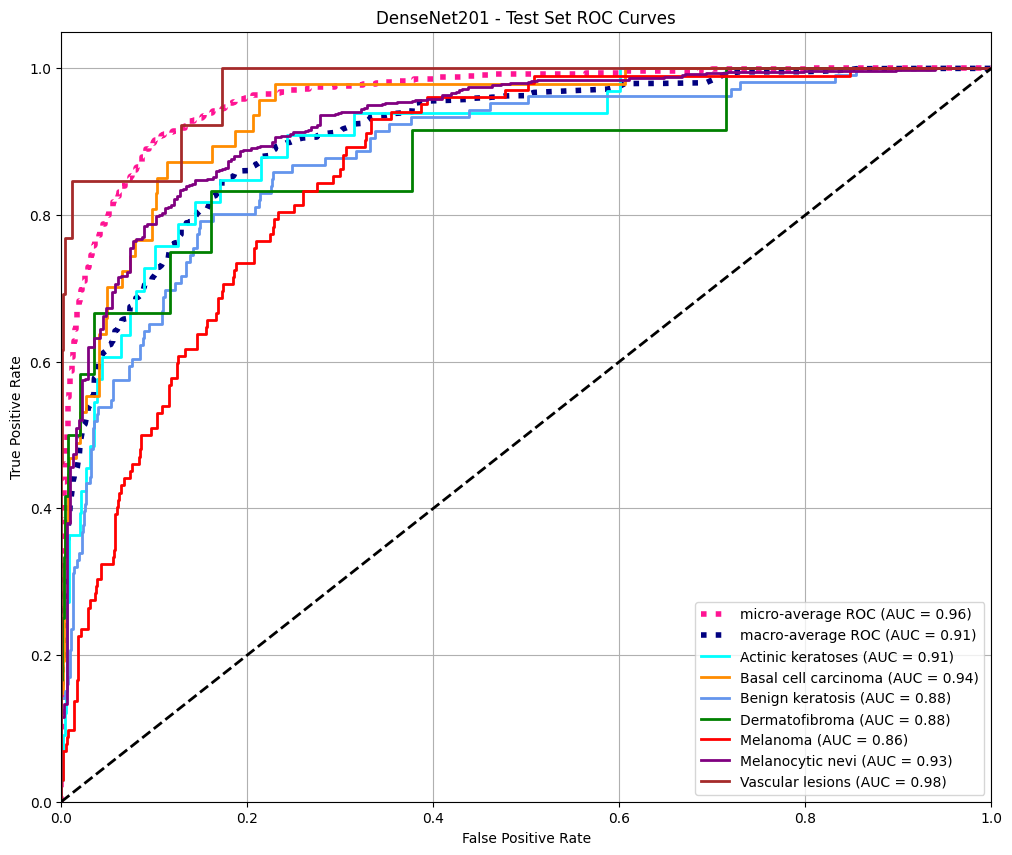


Generating confusion matrix...


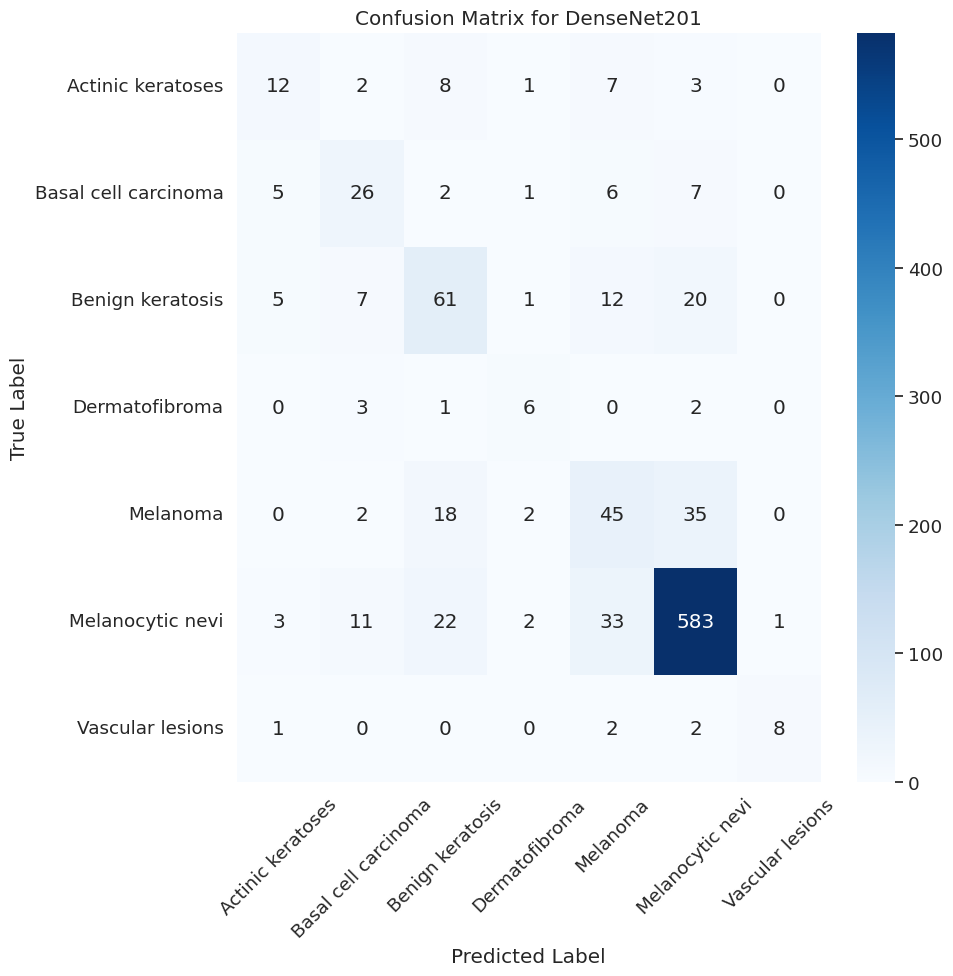


Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.46      0.36      0.41        33
Basal cell carcinoma       0.51      0.55      0.53        47
    Benign keratosis       0.54      0.58      0.56       106
      Dermatofibroma       0.46      0.50      0.48        12
            Melanoma       0.43      0.44      0.43       102
    Melanocytic nevi       0.89      0.89      0.89       655
    Vascular lesions       0.89      0.62      0.73        13

            accuracy                           0.77       968
           macro avg       0.60      0.56      0.58       968
        weighted avg       0.77      0.77      0.77       968



In [8]:
for model_name, config in model_configs.items():
    print("\n================================================")
    print(f"Final Training and Evaluation for model: {model_name}")
    print("================================================")

    img_size = config["img_size"]
    use_rescale = config["use_rescale"]
    model_func = config["model_func"]

    print("\nBalancing full training data for final model...")
    balanced_df_train = balance_data(df_train, oversample=USE_AUGMENTATION_AND_OVERSAMPLING)
    print(f"Final balanced full training set size: {len(balanced_df_train)} samples")

    if use_rescale:
        train_gen_full = tr_gen_rescale.flow_from_dataframe(
            balanced_df_train,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=True,
            batch_size=batch_size
        )
        test_gen = ts_gen_rescale.flow_from_dataframe(
            df_test,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=False,
            batch_size=batch_size
        )
    else:
        train_gen_full = tr_gen_no_rescale.flow_from_dataframe(
            balanced_df_train,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=True,
            batch_size=batch_size
        )
        test_gen = ts_gen_no_rescale.flow_from_dataframe(
            df_test,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=False,
            batch_size=batch_size
        )

    num_classes = len(train_gen_full.class_indices)
    model = model_func(input_shape=(img_size[0], img_size[1], 3), num_classes=num_classes)
    model = compile_model(model)

    final_lr_reduction = ReduceLROnPlateau(
        monitor='accuracy',
        patience=3,
        verbose=1,
        factor=0.5,
        min_lr=0.00001
    )

    print("\n--- Final training on full training data ---")
    history_full = model.fit(
        train_gen_full,
        epochs=num_epochs,
        callbacks=[final_lr_reduction],
        verbose=1
    )

    plot_training_history(history_full, model_name)

    print("\nEvaluating on test set...")
    score = model.evaluate(test_gen)
    loss, accuracy, auc_value = score
    print(f"\nTest Loss for {model_name}: {loss:.4f}")
    print(f"Test Accuracy for {model_name}: {accuracy:.4f}")
    print(f"Test AUC for {model_name}: {auc_value:.4f}")

    print("\nGenerating predictions for ROC curves...")
    y_pred = model.predict(test_gen)
    y_true = np.array(test_gen.classes)
    class_names = list(test_gen.class_indices.keys())

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        y_true_binary = np.array(y_true == i, dtype=int)
        fpr[i], tpr[i], _ = roc_curve(
            y_true_binary,
            y_pred[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(
        tf.keras.utils.to_categorical(y_true, num_classes=num_classes).ravel(),
        y_pred.ravel()
    )
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lesion_names = [lesion_type_dict[key] for key in class_names]
    plot_roc_curves(fpr, tpr, roc_auc, lesion_names, f"{model_name} - Test Set ROC Curves")

    print("\nGenerating confusion matrix...")
    predictions = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, predictions)

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[lesion_type_dict[key] for key in class_names],
                yticklabels=[lesion_type_dict[key] for key in class_names])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(
        y_true,
        predictions,
        target_names=[lesion_type_dict[key] for key in class_names],
        zero_division=0
    ))

    del model
    tf.keras.backend.clear_session()
    gc.collect()